In [ ]:
%%capture

!pip install pafy youtube-dl moviepy


In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


  if event.key is 'enter':



In [ ]:
seed_constant=27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **1.Download and visualize data**

In [ ]:
%%capture

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

!unrar x UCF50.rar

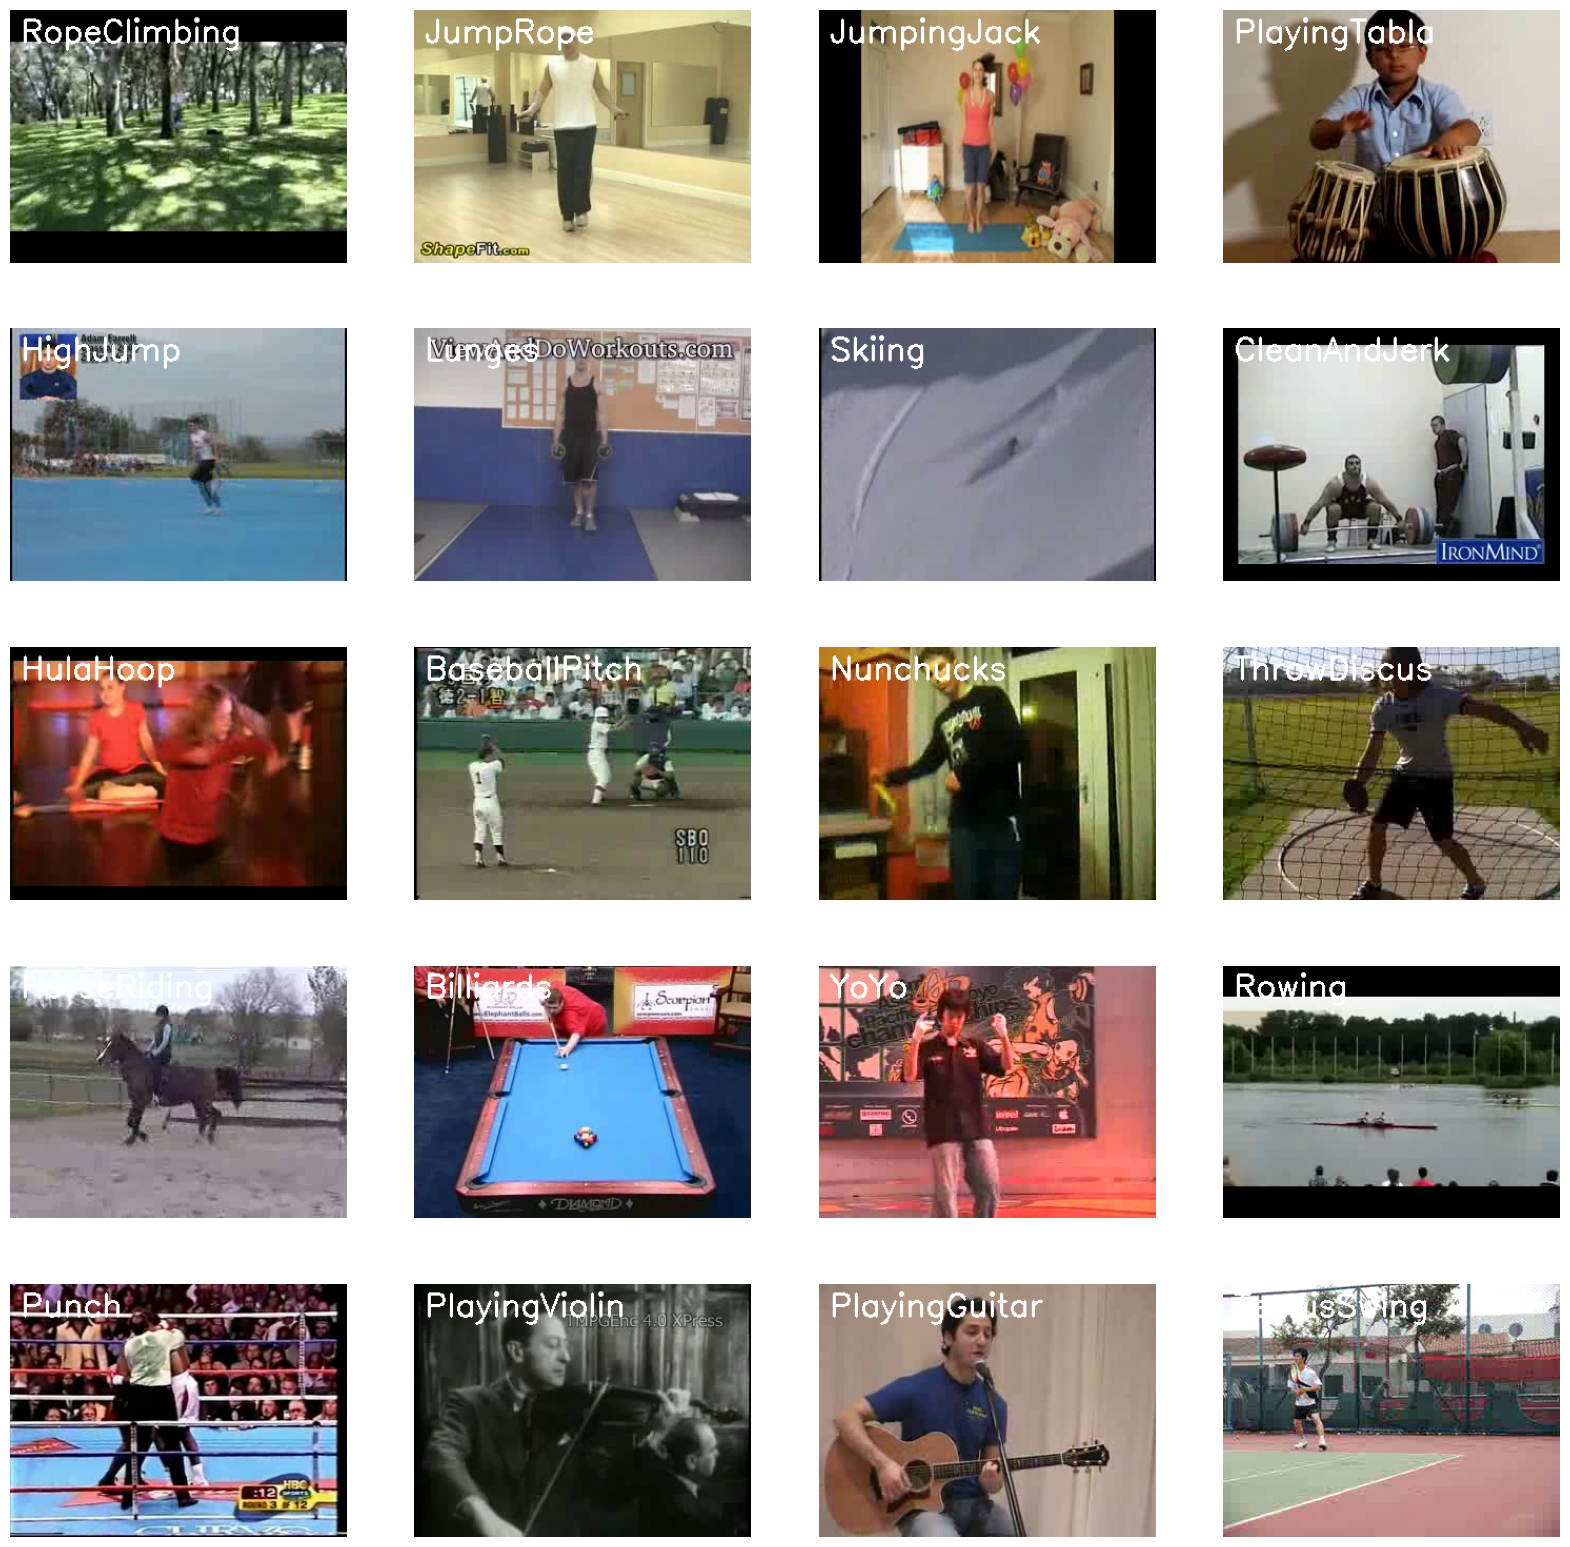

In [ ]:
plt.figure(figsize=(20,20))

all_classes_names=os.listdir('UCF50')

random_range=random.sample(range(len(all_classes_names)),20)

for counter,random_index in enumerate(random_range,1):
  selected_class_Name=all_classes_names[random_index]

  video_files_name_list=os.listdir(f'UCF50/{selected_class_Name}')

  selected_video_file_name=random.choice(video_files_name_list)

  video_reader=cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

  video_reader=cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

  _, bgr_frame=video_reader.read()

  video_reader.release()

  rgb_frame=cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)

  cv2.putText(rgb_frame,selected_class_Name,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

  plt.subplot(5,4,counter);plt.imshow(rgb_frame);plt.axis('off')


## **2.Preprocess the Dataset**

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR="UCF50"
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

### Function to Extract, Resize and Normalize frame

In [ ]:
def frames_extraction(video_path):
  frames_list=[]

  video_reader=cv2.VideoCapture(video_path)

  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_frames_window=max(int(video_frames_count/SEQUENCE_LENGTH),1)

  for frame_counter in range(SEQUENCE_LENGTH):

    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter * skip_frames_window)

    success,frame= video_reader.read()

    if not success:
      break

    resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))

    normal_frame=resized_frame/255

    frames_list.append(normal_frame)

  video_reader.release()

  return frames_list


### Function for Dataset Creation

In [ ]:
def create_dataset():

  features=[]
  labels=[]
  video_files_paths=[]

  for class_index,class_name in enumerate(CLASSES_LIST):

    print(f'Extracting Data of class:{class_name}')

    files_list=os.listdir(os.path.join(DATASET_DIR,class_name))

    for file_name in files_list:

      video_file_path=os.path.join(DATASET_DIR, class_name,file_name)

      frames=frames_extraction(video_file_path)

      if len(frames)== SEQUENCE_LENGTH:
          features.append(frames)
          labels.append(class_index)
          video_files_paths.append(video_file_path)


  features=np.asarray(features)
  labels=np.array(labels)

  return features,labels,video_files_paths


In [ ]:
features,labels,video_files_paths=create_dataset()

Extracting Data of class:WalkingWithDog
Extracting Data of class:TaiChi
Extracting Data of class:Swing
Extracting Data of class:HorseRace


In [ ]:
one_hot_encoded_labels=to_categorical(labels)

## 3.Split the Data into Train and Test

In [ ]:
features_train,features_test,labels_train,labels_test=train_test_split(features,
                                                                       one_hot_encoded_labels,test_size=0.25,
                                                                       shuffle=True,random_state=seed_constant)

# **4.Implement ConvLSTM Approach**

In [ ]:
def create_convlstm_model():
  model=Sequential()


  model.add(ConvLSTM2D(filters=4,kernel_size=(3,3),activation='tanh',data_format="channels_last",
                       recurrent_dropout=0.2,return_sequences=True,input_shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0,2)))

  model.add(ConvLSTM2D(filters=8,kernel_size=(3,3),activation='tanh',data_format="channels_last",
                       recurrent_dropout=0.2,return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0,2)))

  model.add(ConvLSTM2D(filters=14,kernel_size=(3,3),activation='tanh',data_format="channels_last",
                       recurrent_dropout=0.2,return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0,2)))

  model.add(ConvLSTM2D(filters=16,kernel_size=(3,3),activation='tanh',data_format="channels_last",
                       recurrent_dropout=0.2,return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))

  model.add(Flatten())

  model.add(Dense(len(CLASSES_LIST),activation="softmax"))

  model.summary()

  return model

In [ ]:
convlstm_model=create_convlstm_model()

print("Model created successfully!")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          11,524 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,524 (173.92 KB)

 Trainable params: 44,524 (173.92 KB)

 Non-trainable params: 0 (0.00 B)

Model created successfully!


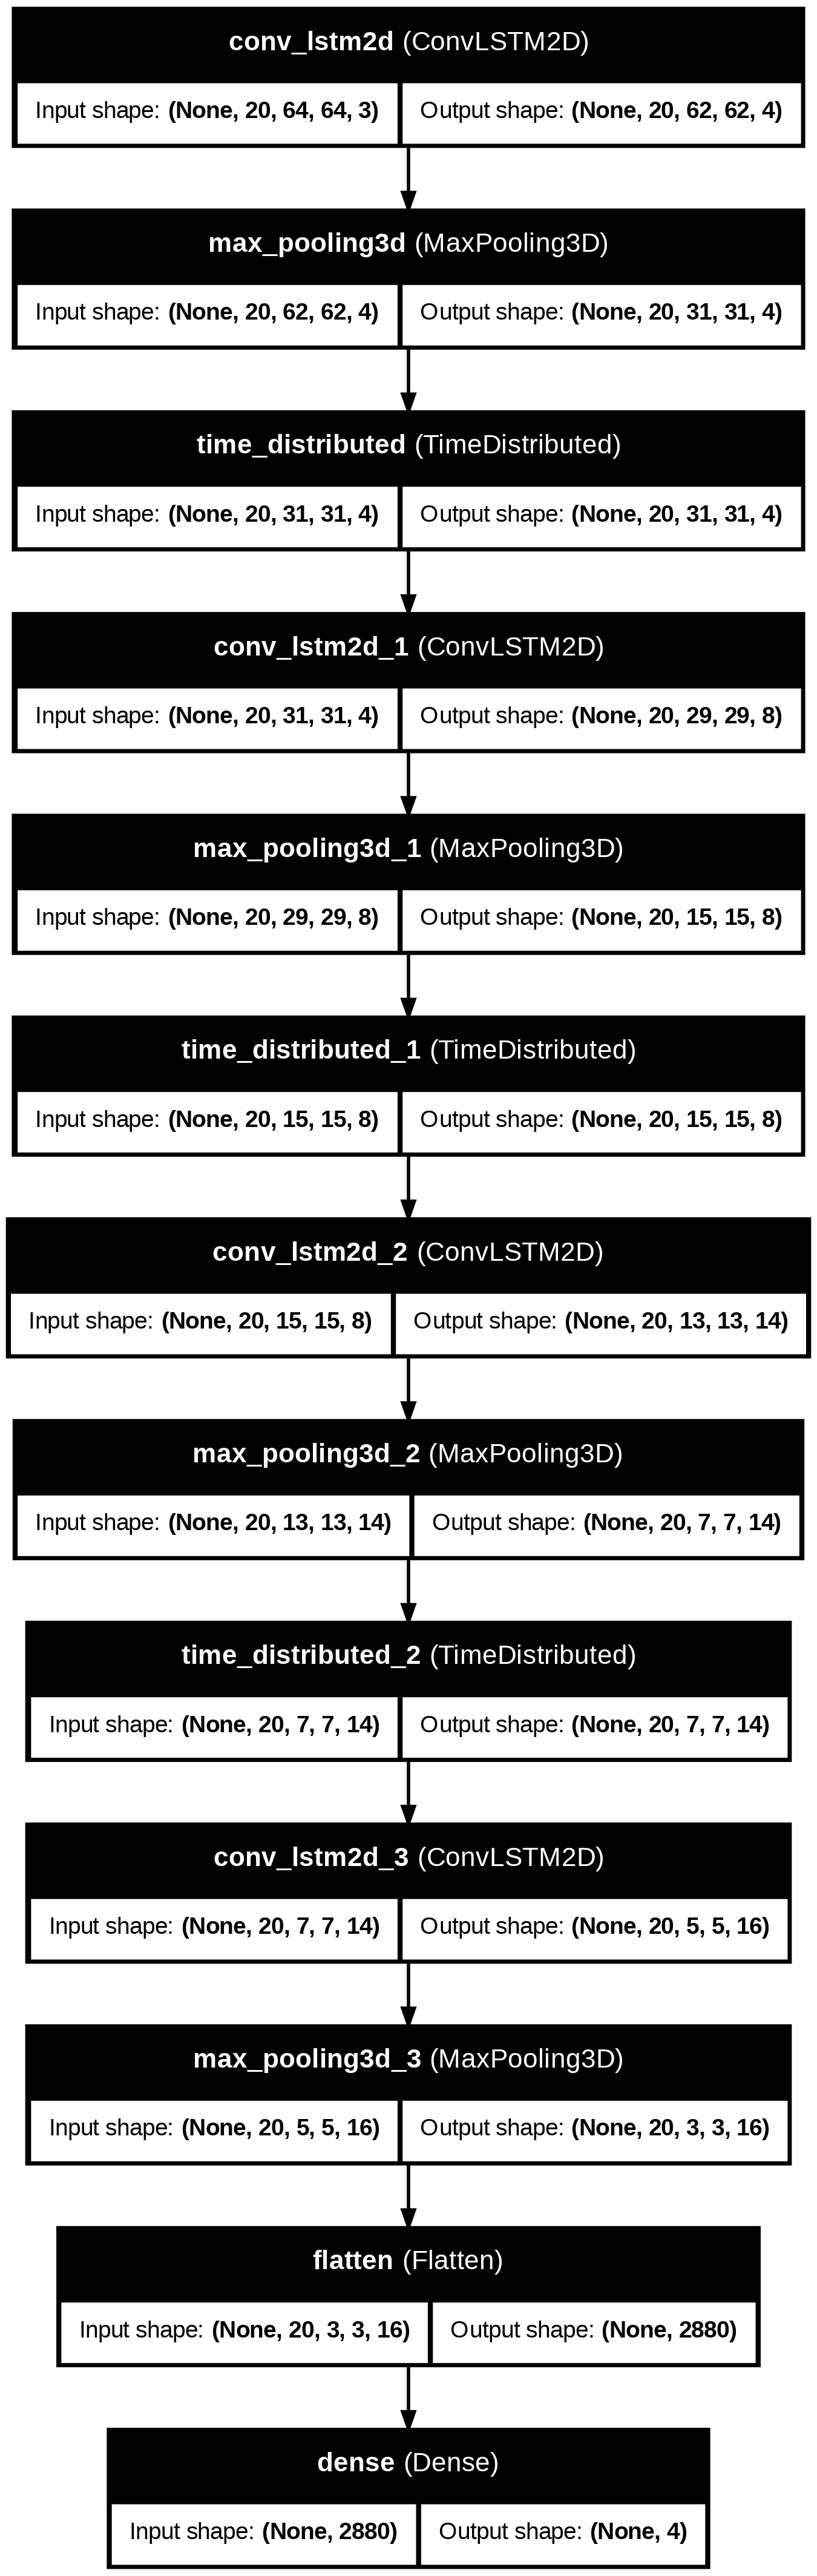

In [ ]:
plot_model(convlstm_model,to_file='convlstm_model_strucure_plot.png',show_shapes=True,show_layer_names=True)

In [ ]:
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)

convlstm_model.compile(loss='categorical_crossentropy',
                       optimizer='Adam',
                       metrics=["accuracy"])

convlstm_model_training_history=convlstm_model.fit(x=features_train,y=labels_train,epochs=50,
                                                   batch_size=4,shuffle=True,validation_split=0.2,
                                                   callbacks=[early_stopping_callback])

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.3152 - loss: 1.3619 - val_accuracy: 0.4658 - val_loss: 1.2449
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.4908 - loss: 1.2171 - val_accuracy: 0.5616 - val_loss: 1.1820
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6303 - loss: 0.9958 - val_accuracy: 0.5753 - val_loss: 0.8469
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6990 - loss: 0.8338 - val_accuracy: 0.6438 - val_loss: 0.7573
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7508 - loss: 0.6436 - val_accuracy: 0.6849 - val_loss: 0.7201
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.7956 - loss: 0.6046 - val_accuracy: 0.6849 - val_loss: 0.7128
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8250 - loss: 0.5224 - val_accuracy: 0.7260 - val_loss: 0.7506
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8763 - loss: 0.3825 - val_accuracy: 0.7671 - v

In [ ]:
 model_evaluation_history=convlstm_model.evaluate(features_test,labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.7866 - loss: 0.5258


### Save the Model

In [ ]:
model_evaluation_loss, model_evaluation_accuracy=model_evaluation_history

date_time_format='%Y_%m_%d_%H_%M_%S'
current_date_time_dt=dt.datetime.now()
current_date_time_string=dt.datetime.strftime(current_date_time_dt,date_time_format)

model_file_name=f'convlstm_model_Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}_Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

### Loss and Accuracy

In [ ]:
def plot_metric(model_training_history,metric_name_1,metric_name_2,plot_name):

  metric_value_1=model_training_history.history[metric_name_1]
  metric_value_2=model_training_history.history[metric_name_2]

  epochs=range(len(metric_value_1))

  plt.plot(epochs,metric_value_1,'blue',label=metric_name_1)
  plt.plot(epochs,metric_value_2,'red',label=metric_name_2)

  plt.title(str(plot_name))

  plt.legend()

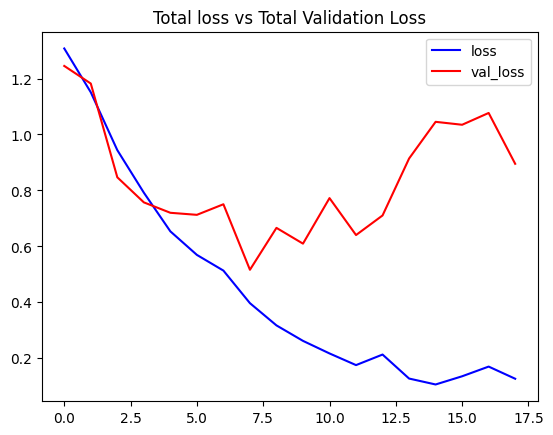

In [ ]:
plot_metric(convlstm_model_training_history,'loss','val_loss','Total loss vs Total Validation Loss')

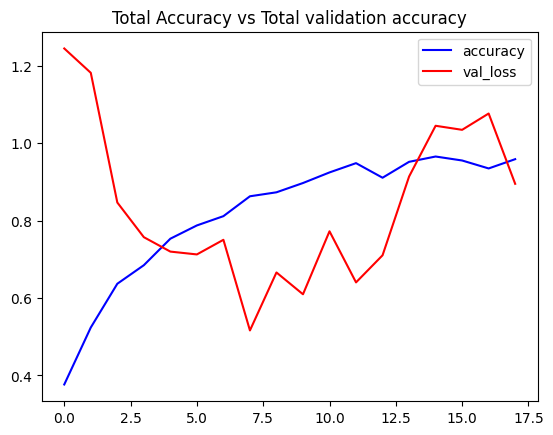

In [ ]:
 plot_metric(convlstm_model_training_history,'accuracy','val_loss','Total Accuracy vs Total validation accuracy')

### **5.Implement LRCN approach**

In [ ]:
def create_LRCN_model():

  model=Sequential()

  model.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),
                            input_shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  model.add(TimeDistributed(MaxPooling2D((2, 2)))) # Change pool size to (2, 2)
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2)))) # Change pool size to (2, 2)
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2)))) # Change pool size to (2, 2)
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2)))) # Change pool size to (2, 2)
  # model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST),activation='softmax'))

  model.summary()

  return model

In [ ]:
LRCN_model=create_LRCN_model()

print("Model created successfully!")

  super().__init__(**kwargs)



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_27                  │ (None, 20, 64, 64, 16)      │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, 20, 32, 32, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 20, 32, 32, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_30                  │ (None, 20, 32, 32, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_31                  │ (None, 20, 16, 16, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_32                  │ (None, 20, 16, 16, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_33                  │ (None, 20, 16, 16, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_34                  │ (None, 20, 8, 8, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_35                  │ (None, 20, 8, 8, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_36                  │ (None, 20, 8, 8, 64)        │          36,928 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_37                  │ (None, 20, 4, 4, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_38                  │ (None, 20, 1024)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │         135,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 195,940 (765.39 KB)

 Trainable params: 195,940 (765.39 KB)

 Non-trainable params: 0 (0.00 B)

Model created successfully!


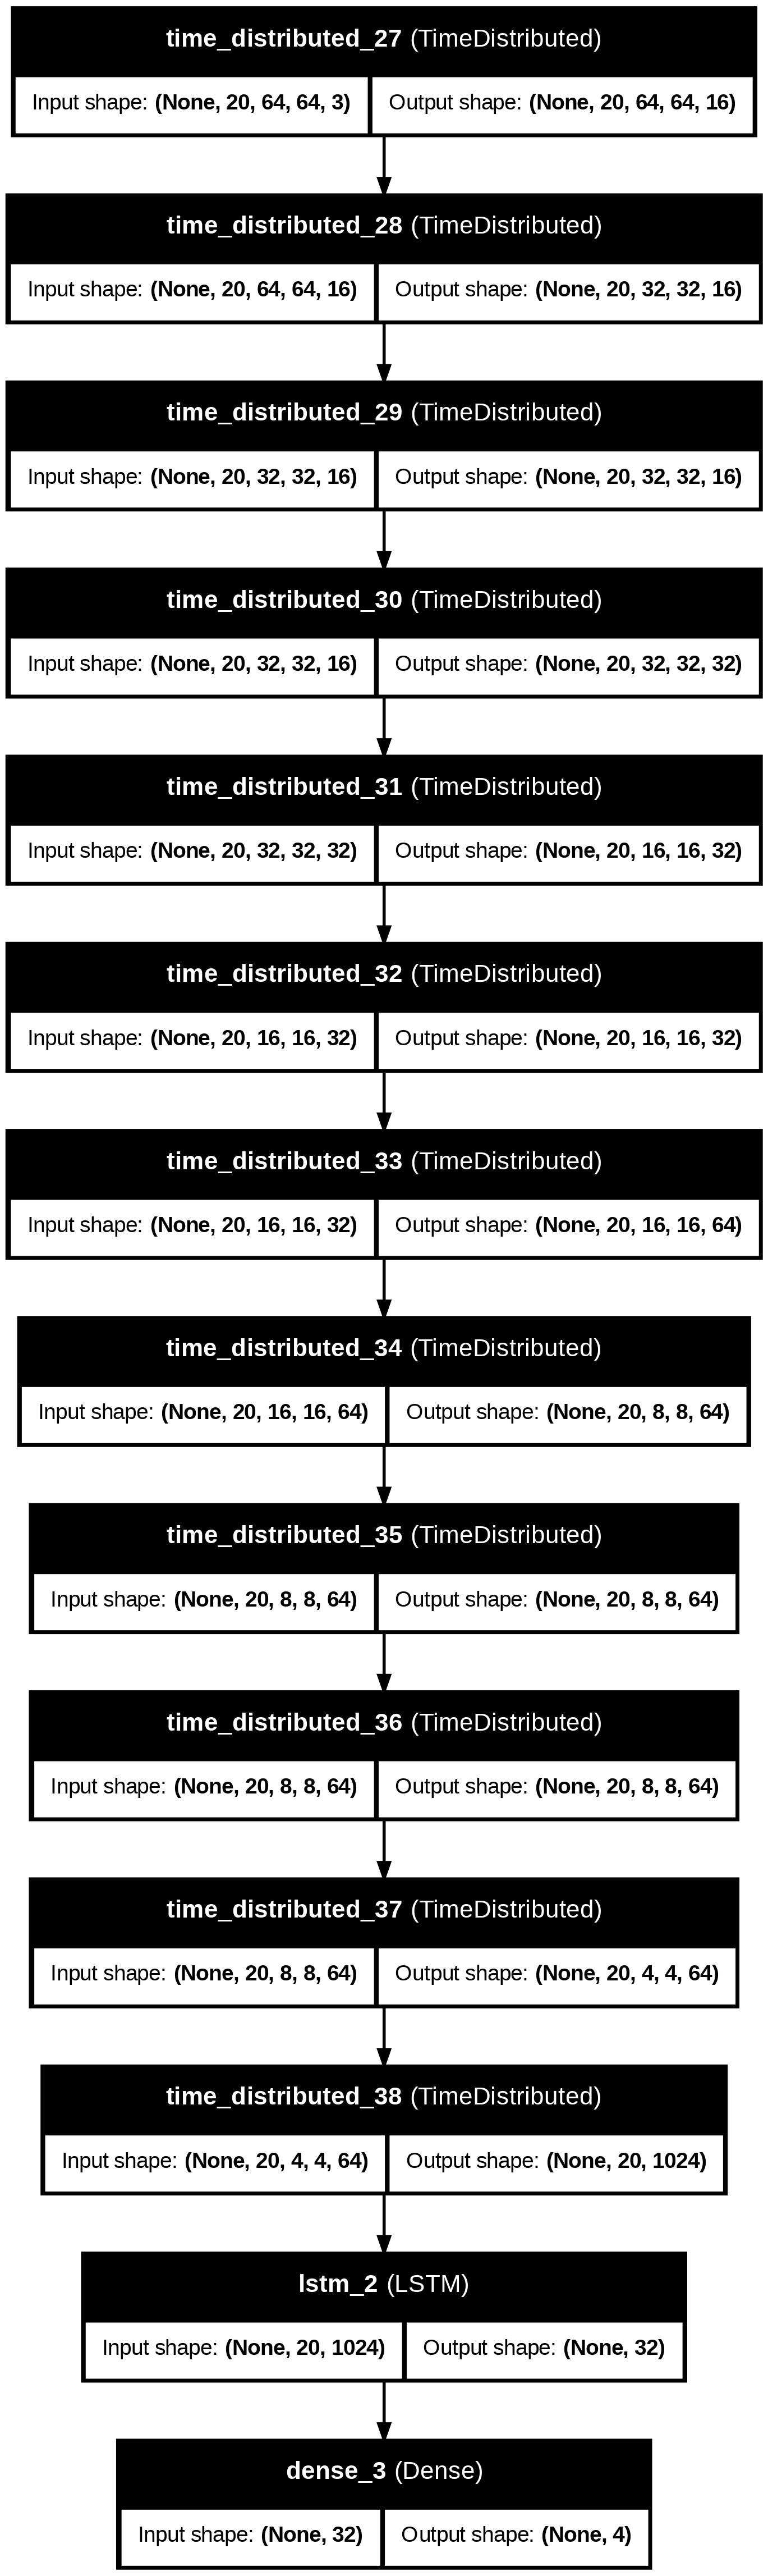

In [ ]:
 plot_model(LRCN_model,to_file='LRCN_model_strucure_plot.png',show_shapes=True,show_layer_names=True)

In [ ]:
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=15,mode='min',restore_best_weights=True)

LRCN_model.compile(loss='categorical_crossentropy',
                       optimizer='Adam',
                       metrics=["accuracy"])

LRCN_model_training_history=LRCN_model.fit(x=features_train,y=labels_train,epochs=70,
                                                   batch_size=4,shuffle=True,validation_split=0.2,
                                                   callbacks=[early_stopping_callback])

Epoch 1/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.2481 - loss: 1.4502 - val_accuracy: 0.4247 - val_loss: 1.2898
Epoch 2/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4495 - loss: 1.2506 - val_accuracy: 0.5342 - val_loss: 1.1009
Epoch 3/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.5365 - loss: 1.1188 - val_accuracy: 0.6438 - val_loss: 0.9497
Epoch 4/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5747 - loss: 1.0055 - val_accuracy: 0.6712 - val_loss: 0.8953
Epoch 5/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6129 - loss: 0.9143 - val_accuracy: 0.6575 - val_loss: 0.8089
Epoch 6/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7044 - loss: 0.7931 - val_accuracy: 0.6986 - val_loss: 0.8358
Epoch 7/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5871 - loss: 0.9682 - val_accuracy: 0.4247 - val_loss: 1.1357
Epoch 8/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5761 - loss: 0.9764 - val_accuracy: 0.6027 - val_

In [ ]:
 LRCN_model_evaluation_history=LRCN_model.evaluate(features_test,labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 940ms/step - accuracy: 0.8090 - loss: 0.5682


In [ ]:
model_evaluation_loss, model_evaluation_accuracy=LRCN_model_evaluation_history

date_time_format='%Y_%m_%d_%H_%M_%S'
current_date_time_dt=dt.datetime.now()
current_date_time_string=dt.datetime.strftime(current_date_time_dt,date_time_format)

model_file_name=f'LCRN_model_Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}_Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

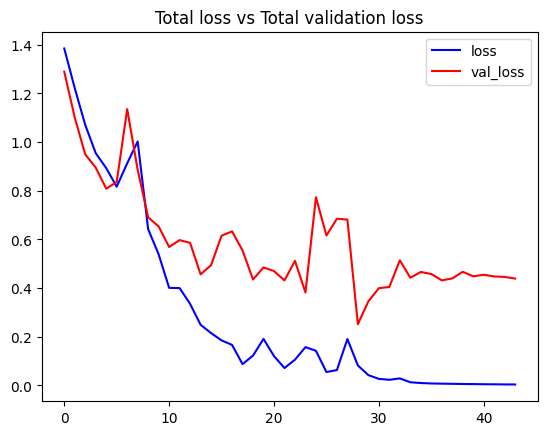

In [ ]:
 plot_metric(LRCN_model_training_history,'loss','val_loss','Total loss vs Total validation loss')

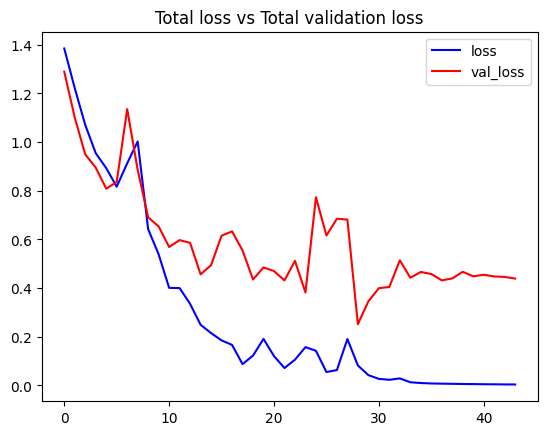

In [ ]:
 plot_metric(LRCN_model_training_history,'loss','val_loss','Total loss vs Total validation loss')

## **6.Test Best Performing Model on Youtube Videos**

## Function to download Youtube Videos:

In [ ]:
def download_youtube_videos(youtube_video_url,output_directory):

  video=pafy.new(youtube_video_url)

  title=video.title

  video_best=video.getbest()

  output_file_path=f'{output_directory}/{title}.mp4'

  video_best.download(filepath=output_file_path,quit=True)

  return title

In [ ]:
def predict_on_video(video_file_path,output_file_path,SEQUENCE_LENGTH):

  video_reader=cv2.VideoCapture(video_file_path)

  original_video_width=int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height=int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  video_writer=cv2.VideoWriter(output_file_path,cv2.VideoWriter_fourcc('M','P','4','V'),
                               video_reader.get(cv2.CAP_PROP_FPS),(original_video_width,original_video_height))

  frame_queue=deque(maxlen=SEQUENCE_LENGTH)

  predicted_class_name=''

  while video_reader.isOpened():

    ok,frame=video_reader.read()

    if not ok:
      break

    resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))

    normalized_frame=resized_frame/255

    frames_queue.append(normalized_frame)

    if len(frames_queue) == SEQUENCE_LENGTH:

      predict_labels_probabilities=LRCN_model.predict(np.expand_dims(frames_queue,axis=0))[0]

      predicted_label=np.argmax(predict_labels_probabilities)

      predicted_class_name=CLASSES_LIST[predicted_label]

    cv2.putText(frame,predicted_class_name,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

    video_writer.write(frame)

  video_reader.release()
  video_writer.release()


In [ ]:
test_videos_directory=os.

### Perform Action Recognition

In [ ]:
# output_video_file_path=f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
output_video_file_path=f'/content/test_videos_directory/Road Bikes are Beautiful.mp4'
input_video_file_path=f'/content/test_videos_directory'

predict_on_video(input_video_file_path,output_video_file_path,SEQUENCE_LENGTH)

from moviepy.editor import VideoFileClip
VideoFileClip(output_video_file_path,audio=False,target_resolution=(300,None)).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  98%|█████████▊| 503/513 [00:02<00:00, 159.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/test_videos_directory/Road Bikes are Beautiful.mp4, 151200 bytes wanted but 0 bytes read,at frame 512/513, at time 21.35/21.36 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
def predict_single_action(video_file_path,SEQUENCE_LENGTH):

  video_reader=cv2.VideoCapture(video_file_path)

  original_video_width=int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height=int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  frame_list=[]

  predicted_class_name=''

  video_frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_frames_window=max(int(video_frame_count/SEQUENCE_LENGTH),1)

  for frame_counter in range(SEQUENCE_LENGTH):

    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter * skip_frames_window)

    success, frame= video_reader.read()

    if not success:
      break

    resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))

    normalized_frame=resized_frame/255

    frame_list.append(normalized_frame)

  predict_labels_probabilities=LRCN_model.predict(np.expand_dims(frame_list,axis=0))[0]

  predicted_label=np.argmax(predict_labels_probabilities)

  predicted_class_name=CLASSES_LIST[predicted_label]

  print(f'Action predicted:{predicted_class_name}\nConfidence:{predict_labels_probabilities[predicted_label]}')

  video_reader.release()

In [ ]:
test_videos_directory=f'/content/test_videos_directory'
# input_video_file_path=f'{test_videos_directory}/{video_title}'
input_video_file_path=f'/content/test_videos_directory/Road Bikes are Beautiful.mp4'
predict_single_action(input_video_file_path,SEQUENCE_LENGTH)

VideoFileClip(input_video_file_path,audio=False,target_resolution=(300,None)).ipython_display()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Action predicted:Swing
Confidence:0.5408484935760498
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  96%|█████████▋| 495/513 [00:02<00:00, 258.14it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/test_videos_directory/Road Bikes are Beautiful.mp4, 151200 bytes wanted but 0 bytes read,at frame 512/513, at time 21.35/21.36 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4
